## SN 2022abik 2022-12-1415

### Observing Notes

Another round 30 60-second exposures each in g', r', and i', this time, proceeding across series rather than doing all of g' first.

TheSkyX crashed when approximately 80 of the planned 90 images had been taken.

### Calibration Photos

The calibration photos are in 2022-11-3001.

The bias photos should be discarded in favor of the 1-second and 30-second darks. It turns out TheSkyX ignores the exposure time
set on bias photos and does some very rapid exposure. I would not have noticed this if I had not needed some 30-second
bias files.

The 30-second darks are needed because the i' flats required 30 seconds to get a reasonable value.

In [1]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.coordinates import SkyCoord
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa
import twirl

# Only the following group of constants should need to be adjusted, typically, from one analysis to the next.
observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
filters = ['g', 'r']
filter_full_names = ["Sloan g'", "Sloan r'"]
light_exposure = 60 * u.second
flat_exposure = 1 * u.second
BINNING = 2  # 2x2 binning
SUBFRAMING = 2  # For "Half" Subframing
UNBINNED_PLATE_SCALE = 0.239
WIDTH_HEIGHT = (8288, 5644)
plate_scale = UNBINNED_PLATE_SCALE * BINNING * u.arcsec
# Our sensor is spec'd as 8288x5644, but when binned 2x2 and half-subframed, it writes out 4 columns of NaNs.
# Therefore, we treat it as if it had 16 fewer columns, e.g., we treat it as if it was 8272x5644. This bins
# and subframes to 2068 columns and 1411 rows, or about 0.275x0.187 degrees. Only the larger dimension is used.
fov = np.max((8272, 5644)) / BINNING / SUBFRAMING * plate_scale.to(u.deg).value
# Conveniences for referring to filters
SLOAN_G_FILTER = 0
SLOAN_R_FILTER = 1

dark_exposure = light_exposure  # our method presumes this equality
bias_exposure = flat_exposure  # our method presumes this equality

# directories where the observation and calibration images being analyzed are kept
observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

# Log stretch utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        # if pixel_value != pixel_value or pixel_value <= 1.0:
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

# Trimmed image reader utility (needed because our images have four columns of NaNs)

def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    trimmed_data = delete_last_columns(data, 4)
    img.data = trimmed_data
    return img



In [2]:
#Load Science and Calibration Images

# subdirectories -- relative to observation and calibration directories

light_directories = [os.path.join(observation_directory, filter) for filter in filters]

# the 60-second darks
dark_directory = os.path.join(calibration_directory, 'dark')

# the 1-second g and r flats
flat_directories = [os.path.join(calibration_directory, 'flat', filter) for filter in filters]

# the 1-second darks/biases
bias_directory = os.path.join(calibration_directory, 'bias')

light_files_list = [ImageFileCollection(light_directory).files_filtered(include_path='True')
               for light_directory in light_directories]
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files_list = [ImageFileCollection(flat_directory).files_filtered(include_path='True')
               for flat_directory in flat_directories]
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

lights_list = [[trimmed_image_reader(file) for file in light_files] for light_files in light_files_list]
darks = [trimmed_image_reader(file) for file in dark_files]
flats_list = [[trimmed_image_reader(file) for file in flat_files] for flat_files in flat_files_list]
biases = [trimmed_image_reader(file) for file in bias_files]

# the aligned directories are written to not read from
aligned_directory_list = [os.path.join(light_directory, 'aligned') for light_directory in light_directories]

for aligned_directory in aligned_directory_list:
    if not os.path.exists(aligned_directory):
        os.makedirs(aligned_directory)




Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [3]:
#Calibration

method = 'median'  # the method can be changed to 'average'

master_dark = combine(darks, method=method)
master_flat_list = [combine(flats, method=method) for flats in flats_list]
master_bias = combine(biases, method=method)

lights_subtracted_list = [[subtract_dark(light,
                                   master_dark,
                                   data_exposure=light_exposure,
                                   dark_exposure=dark_exposure,
                                   scale=False)
                           for light in lights] for lights in lights_list]

# Perform dark subtraction

master_flat_subtracted_list = [subtract_dark(master_flat,
                                       master_bias,
                                       data_exposure=flat_exposure,
                                       dark_exposure=bias_exposure,
                                       scale=False)
                               for master_flat in master_flat_list]

# Perform flat division
               
lights_calibrated_list = [[flat_correct(l, master_flat_subtracted_list[i]) for l in lights_subtracted_list[i]]
                          for i in range(len(filters))]

In [4]:
# First grab some sample uncalibrated lights

sample_lights = [lights[0] for lights in lights_list]
sample_data_list = [np.asarray(sample_light) for sample_light in sample_lights]

# Median subtract

medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_data_list]
subtracted = [sample_data_list[i] - medians[i] for i in range(len(filters))]

# Then grab some sample calibrated lights

sample_calibrated_lights = [lights[0] for lights in lights_calibrated_list]
sample_calibrated_data_list = [np.asarray(sample_calibrated_light)
                               for sample_calibrated_light in sample_calibrated_lights]

# Median subtract

calibrated_medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_calibrated_data_list]
calibrated_subtracted = [sample_calibrated_data_list[i] - calibrated_medians[i] for i in range(len(filters))]

In [5]:
# Log stretch uncalibrated

stretch_function = log_stretch_transform(7, 50)
transform = np.vectorize(stretch_function)
transformed_sample_lights = [transform(data) for data in subtracted]

# Log stretch calibrated (potentially with a different stretching function)

stretch_function2 = log_stretch_transform(7, 50)
transform2 = np.vectorize(stretch_function2)
transformed_sample_calibrated_lights = [transform2(data) for data in calibrated_subtracted]

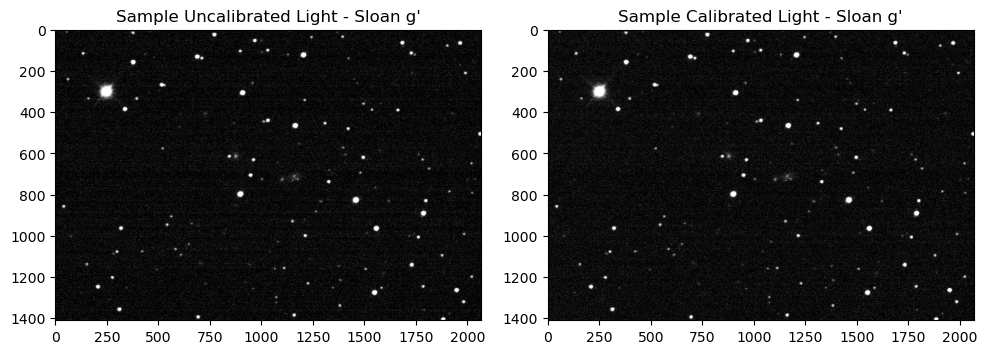

In [6]:
# Display first filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SLOAN_G_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SLOAN_G_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SLOAN_G_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

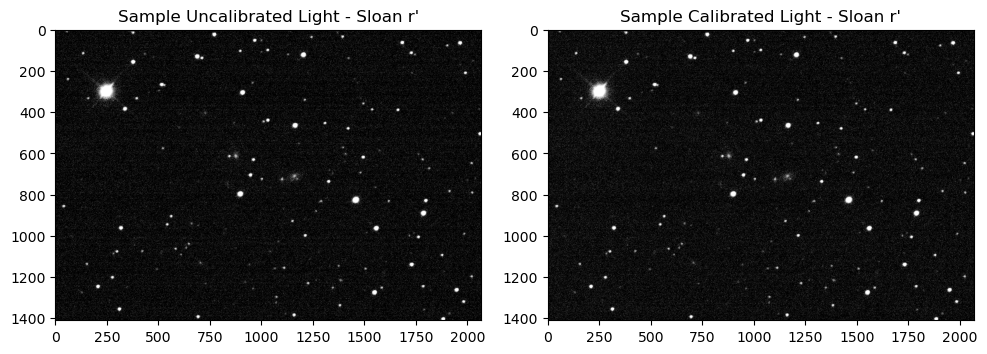

In [7]:
# Display second filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SLOAN_R_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SLOAN_R_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SLOAN_R_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

In [8]:
reference_light_list = [lights_calibrated[0] for lights_calibrated in lights_calibrated_list]

lights_aligned_with_footprints_list = [[aa.register(l, reference_light_list[i], detection_sigma=3.0) for
                                        l in lights_calibrated_list[i]] for i in range(len(filters))]

In [9]:
for i in range(len(filters)):
    # First we pick out all the stuff for a given filter
    lights = lights_list[i]
    light_files = light_files_list[i]
    lights_aligned_with_footprints = lights_aligned_with_footprints_list[i]
    aligned_directory = aligned_directory_list[i]
    for j in range(len(lights_aligned_with_footprints)):
        # Then we write all the files for that filter
        light_header = lights[j][0].header
        light_aligned_data = lights_aligned_with_footprints[j][0]
        aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[j]))
        aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
        fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)

In [10]:
# we'll have to do this for each filter, so make some empty lists to append to
first_light_list = []  # this contains the whole first fits file for each filter
combined_light_list = []  # this contains the combined light data for each filter

for i in range(len(filters)):
    aligned_directory = aligned_directory_list[i]
    aligned_files = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
    first_light_list.append(fits.open(aligned_files[0]))
    lights = [CCDData.read(file, unit=u.adu) for file in aligned_files]
    combined_light_list.append(combine(lights, method=method))

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [11]:
stacked_data_list = [np.asarray(combined_light) for combined_light in combined_light_list]

# Median subtract

medians_list = [np.median(stacked_data, axis=1, keepdims=True) for stacked_data in stacked_data_list]
stacked_subtracted_list = [stacked_data_list[i] - medians_list[i] for i in range(len(filters))]

# Log stretch

stretch_function3 = log_stretch_transform(0, 100)
transform3 = np.vectorize(stretch_function3)
transformed_stacked_subtracted_list = [[transform3(data) for data in stacked_subtracted]
                                       for stacked_subtracted in stacked_subtracted_list]

#### Display

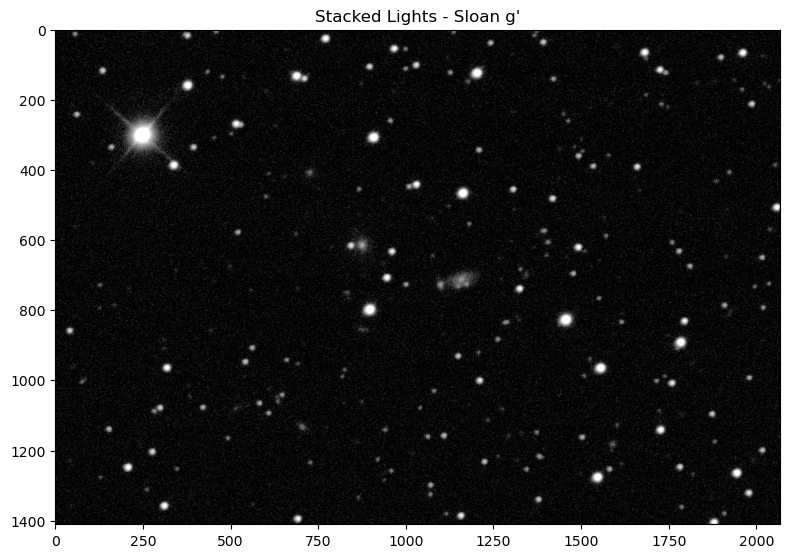

In [12]:
# Stacked Sloan g' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_G_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

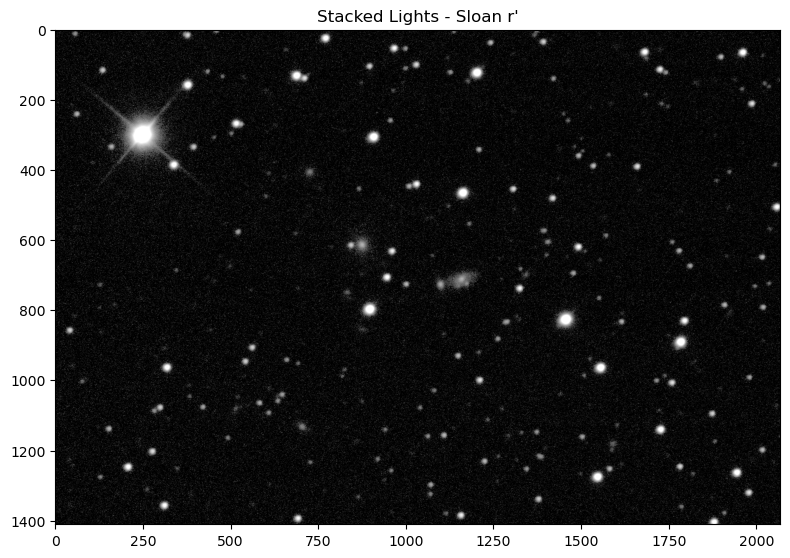

In [13]:
# Stacked Sloan r' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_R_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

### Plate-Solve and Write the Stacked Images

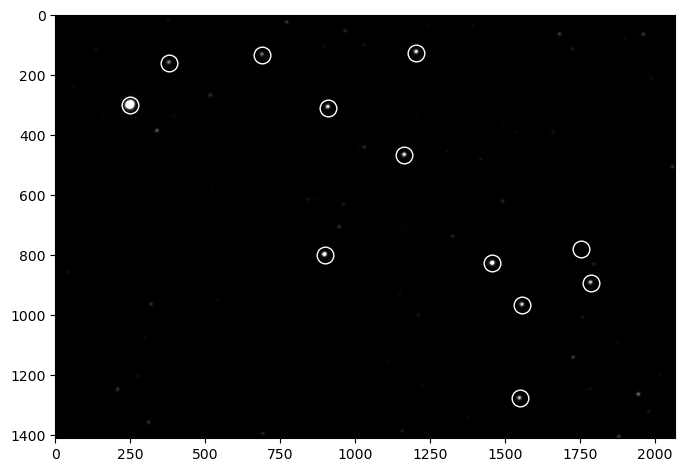

In [14]:
header_list = [light[0].header for light in first_light_list]
center_list = [SkyCoord(header['OBJCTRA'], header['OBJCTDEC'], unit=(u.hourangle, u.deg)) for header in header_list]

center = center_list[SLOAN_G_FILTER]
data = stacked_data_list[SLOAN_G_FILTER]
stars = twirl.find_peaks(stacked_data_list[SLOAN_G_FILTER])[0:15]

plt.figure(figsize=(8,8))
med = np.median(data)
plt.imshow(stacked_data_list[0], cmap="Greys_r", vmax=np.std(data)*5 + med, vmin=med)
plt.plot(*stars.T, "o", fillstyle="none", c="w", ms=12)



In [15]:
# we can now compute the WCS
gaias = twirl.gaia_radecs(center, fov/2, limit=20)
wcs = twirl._compute_wcs(stars, gaias)

TypeError: 'Longitude' object with a scalar value does not support indexing

### PSF Test Code

#### PSF

In [16]:
from photutils.psf import IterativelySubtractedPSFPhotometry
>>> my_photometry = IterativelySubtractedPSFPhotometry(
...     finder=my_finder, group_maker=my_group_maker,
...     bkg_estimator=my_bkg_estimator, psf_model=my_psf_model,
...     fitter=my_fitter, niters=3, fitshape=(7, 7))
>>> # get photometry results
>>> photometry_results = my_photometry(image=my_image)
>>> # get residual image
>>> residual_image = my_photometry.get_residual_image()

NameError: name 'my_finder' is not defined

### Performing PSF Photometry

In [17]:
import numpy as np
>>> from astropy.table import Table
>>> from photutils.datasets import (make_gaussian_sources_image,
...                                 make_noise_image)
>>> sigma_psf = 2
>>> sources = Table()
>>> sources['flux'] = [700, 800, 700, 800]
>>> sources['x_mean'] = [12, 17, 12, 17]
>>> sources['y_mean'] = [15, 15, 20, 20]
>>> sources['x_stddev'] = sigma_psf * np.ones(4)
>>> sources['y_stddev'] = sources['x_stddev']
>>> sources['theta'] = [0, 0, 0, 0]
>>> sources['id'] = [1, 2, 3, 4]
>>> tshape = (32, 32)
>>> image = (make_gaussian_sources_image(tshape, sources) +
...          make_noise_image(tshape, distribution='poisson', mean=6.0,
...                           seed=123) +
...          make_noise_image(tshape, distribution='gaussian', mean=0.0,
...                           stddev=2.0, seed=123))

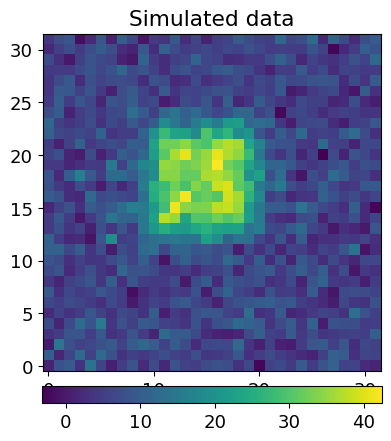

In [18]:
# Plotting the gaussian image

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 13
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',
            origin='lower')  
plt.title('Simulated data')  
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)  

In [19]:
#Iteratively Subtracted PSF Photometry object:

from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import IRAFStarFinder
from photutils.psf import (DAOGroup, IntegratedGaussianPRF,
                           IterativelySubtractedPSFPhotometry)

In [20]:
#instantiate and use the objects:

In [21]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf * gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11, 11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

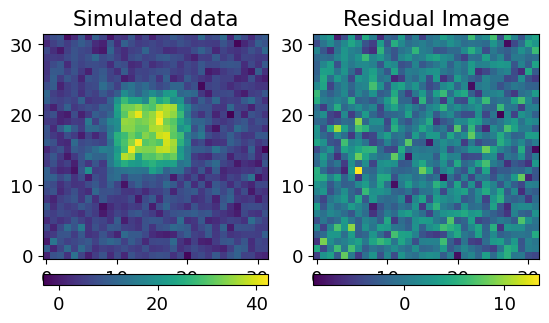

In [22]:
# compare the simulated and the residual images

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',
               origin='lower')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()

##### Additional Parameter

In [23]:
# Fitting Additional Parameters

gaussian_prf = IntegratedGaussianPRF()

# Making sigma able to be modified
gaussian_prf.sigma.fixed = False

# Modifiying Sigma
gaussian_prf.sigma.value = 10

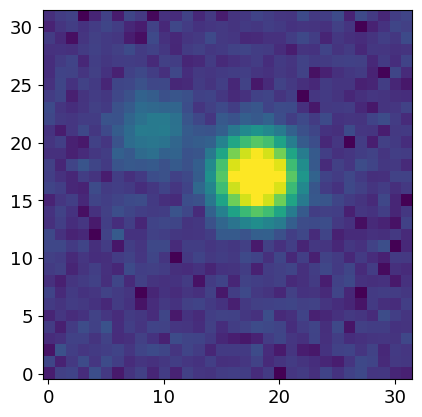

In [24]:
# Producing Image with Overlapping Stars

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.visualization import simple_norm
from matplotlib.colors import LogNorm
from photutils.datasets import (make_gaussian_sources_image,
                                make_noise_image)

sources = Table()
sources['flux'] = [10000, 1000]
sources['x_mean'] = [18, 9]
sources['y_mean'] = [17, 21]
sources['x_stddev'] = [2] * 2
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0] * 2
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources)
         + make_noise_image(tshape, distribution='poisson', mean= 6.0,
                            seed=123)
         + make_noise_image(tshape, distribution='gaussian', mean=0.0,
                            stddev=2.0, seed=123))
norm = simple_norm(image, 'sqrt', percent=98.)
plt.imshow(image, interpolation='nearest', origin='lower', norm=norm)

In [25]:
# Instaniate Objects Necessary to Perform PSF

In [26]:
daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()
iraffind = IRAFStarFinder(threshold=2.5 * mmm_bkg(image), fwhm=4.5)
fitter = LevMarLSQFitter()
gaussian_prf = IntegratedGaussianPRF(sigma=3.05)
gaussian_prf.sigma.fixed = False
itr_phot_obj = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                  group_maker=daogroup,
                                                  bkg_estimator=mmm_bkg,
                                                  psf_model=gaussian_prf,
                                                  fitter=fitter,
                                                  fitshape=(11, 11),
                                                  niters=2)

In [27]:
# Call Object to Perfomr PSF

In [28]:
phot_results = itr_phot_obj(image)
>>> phot_results['id', 'group_id', 'iter_detected', 'x_0', 'y_0', 'flux_0']

id,group_id,iter_detected,x_0,y_0,flux_0
int64,int64,int64,float64,float64,float64
1,1,1,18.003510396149217,17.001996637752185,10063.35501989595
1,1,2,18.003847182485693,17.00139895501012,1466.8910731473543


In [29]:
phot_results['sigma_0', 'sigma_fit', 'x_fit', 'y_fit', 'flux_fit'] 

sigma_0,sigma_fit,x_fit,y_fit,flux_fit
float64,float64,float64,float64,float64
3.05,1.9783476763491215,18.00528416820048,17.00815018506651,9988.054196046343
3.05,1.3621027750080943,18.006084391673223,16.996909707342432,3107.4686676959227


In [30]:
phot_results

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,sigma_0,sigma_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,sigma_unc,iter_detected
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64
18.003510396149217,18.00528416820048,17.001996637752185,17.00815018506651,10063.35501989595,9988.054196046343,3.05,1.9783476763491215,1,1,34.442239612324784,0.006875428555694159,0.006875428981479286,0.004938198604140458,1
18.003847182485693,18.006084391673223,17.00139895501012,16.996909707342432,1466.8910731473543,3107.4686676959227,3.05,1.3621027750080943,1,1,143.24804960839325,0.06419003165343673,0.06419002839148531,0.04643223774128899,2


### ePSF

[The documentation](https://photutils.readthedocs.io/en/stable/psf.html#fitting-additional-parameters) says that this can be used to model galactic backgrounds.